In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Hyperparameters
CURVATURE = -1
DIMENSION = 2
N_SAMPLES = 100

X shape: torch.Size([100, 3])
Dists shape: torch.Size([100, 100])


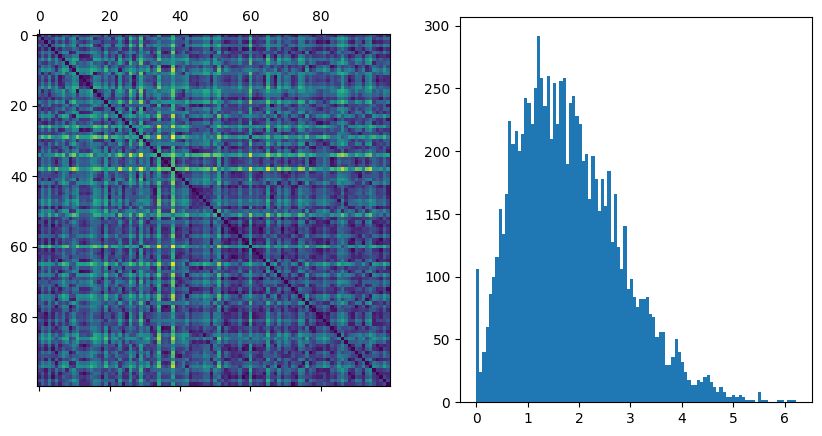

In [4]:
# What is the distribution of deltas for a random manifold?
import torch
import matplotlib.pyplot as plt

from manify.manifolds import ProductManifold

# Initialize product manifold and sample some points
pm = ProductManifold(signature=[(CURVATURE, DIMENSION)])
X, _ = pm.sample(z_mean=torch.stack([pm.mu0] * N_SAMPLES))
print(f"X shape: {X.shape}")

# Get distances
dists = pm.pdist(X)
print(f"Dists shape: {dists.shape}")

# What is the distribution of pairwise distances?
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].matshow(dists.detach().cpu().numpy())
axs[1].hist(dists.detach().cpu().numpy().flatten(), bins=100)
plt.show()

In [5]:
from manify.curvature_estimation.delta_hyperbolicity import delta_hyperbolicity, old_delta_hyperbolicity

d_test = delta_hyperbolicity(dists)
d_ground = old_delta_hyperbolicity(dists)

print(f'ground delta: {d_ground}, test delta: {d_test}')

ground delta: 0.18267585337162018, test delta: tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -5.8143e-01, -2.5039e-01,  ..., -1.4074e-01,
          -1.6548e-01, -1.5260e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -3.3104e-01,  0.0000e+00,  ..., -8.0404e-03,
           5.5921e-02,  2.256

Deltas shape: torch.Size([100, 100, 100])
Max delta: 3.566009998321533
Ground Delta: tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00]],

        [[ 0.0000e+00, -5.8143e-01, -2.5039e-01,  ..., -1.4074e-01,
          -1.6548e-01, -1.5260e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 0.0000e+00, -3.3104e-01,  0.0000e+00,  ..., -8.0

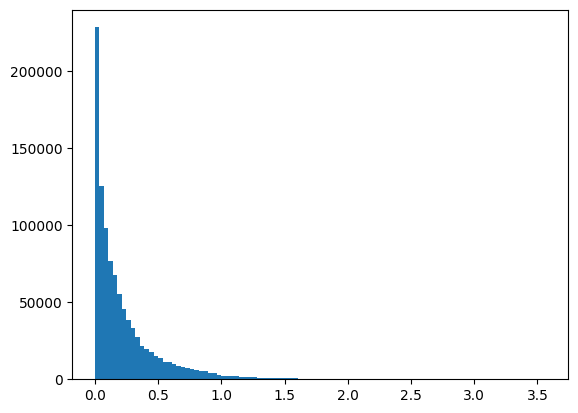

In [6]:
# What is the distribution of deltas?
from manify.curvature_estimation.delta_hyperbolicity import (
    delta_hyperbolicity,
    delta_full,
)

D_FUNC = delta_full

deltas = D_FUNC(dists)
delta_actual = delta_hyperbolicity(dists)
print(f"Deltas shape: {deltas.shape}")  # TODO: this should be N x N x N, I believe - we need to find the other N
print(f"Max delta: {deltas.max().item()}")
print(f'Ground Delta: {delta_actual}')

plt.hist(deltas.detach().cpu().numpy().flatten(), bins=100)
plt.show()

In [7]:
# Experiment 1: How does delta change with curvature?

import seaborn as sns
import numpy as np

# Thought: re-sampling different manifolds is gonna take a lot of time and also introduce stochasticity.
# Instead, we can use the exponenital map for a single sample.

Ks = [-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0]
Ks = np.linspace(-3.0, 0.0, 15).tolist()

# Get a single sample
N = torch.distributions.MultivariateNormal(loc=torch.zeros(DIMENSION), covariance_matrix=torch.eye(DIMENSION))

# Get a single sample and raise to tangent plane (prepend with zero)
x = N.sample(sample_shape=(N_SAMPLES,))
x_tangent = torch.hstack([torch.zeros(N_SAMPLES, 1), x])

all_deltas = []
ground_deltas = []
full_deltas = []
for K in Ks:
    print(f"Curvature: {K}")
    pm_K = ProductManifold(signature=[(K, DIMENSION)])

    # Get the exponential map
    if K == 0.0:
        x_exp = x
    else:
        x_exp = pm_K.expmap(x_tangent)

    # Get the distance
    dists = pm_K.pdist(x_exp)
    deltas = D_FUNC(dists)
    ground_deltas.append(delta_hyperbolicity(dists).item())
    full_deltas.append(deltas.max().item())

    all_deltas.append(deltas)
print(f'Ground deltas: {ground_deltas}')
print(f'Full delta maxs: {full_deltas}')

# Make seaborn kdeplots for each curvature
colors = sns.color_palette("husl", len(Ks))
for i, deltas in enumerate(all_deltas):
    sns.kdeplot(deltas.detach().cpu().numpy().flatten(), label=f"Curvature: {Ks[i]}", color=colors[i])
plt.xlabel("Delta-hyperbolicity value")
plt.ylabel("Density")
plt.title("Distribution of delta-hyperbolicity values for different curvatures")
plt.legend()
plt.show()

Curvature: -3.0


RuntimeError: a Tensor with 1000000 elements cannot be converted to Scalar

Delta means: [-0.1535373330116272, -0.15538735687732697, -0.15733347833156586, -0.15938425064086914, -0.1615496426820755, -0.1638413816690445, -0.1662720888853073, -0.16885575652122498, -0.17161135375499725, -0.17456164956092834, -0.17773520946502686, -0.18116962909698486, -0.1849152147769928, -0.1890343874692917, -0.1936008185148239]
Actuals: [0.38676464557647705, 0.40067338943481445, 0.41607487201690674, 0.4331982135772705, 0.45229268074035645, 0.47359609603881836, 0.4944190979003906, 0.5231260061264038, 0.5543816089630127, 0.5872039794921875, 0.6287539005279541, 0.70326828956604, 0.7980834245681763, 0.8402342796325684, 1.0119346380233765]


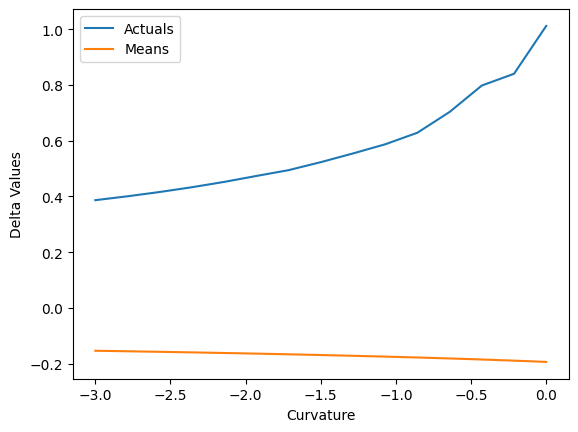

In [10]:
# Exp 1 con't: Mean vs Max values for various curvatures

Actuals = [deltas.max().item() for deltas in all_deltas]
Means = [deltas.mean().item() for deltas in all_deltas]

print(f'Delta means: {Means}')
print(f'Actuals: {Actuals}')


plt.plot(Ks,Actuals, label="Actuals")
plt.plot(Ks,Means, label="Means")
plt.xlabel('Curvature')
plt.ylabel('Delta Values')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Distance between points on different manifolds')

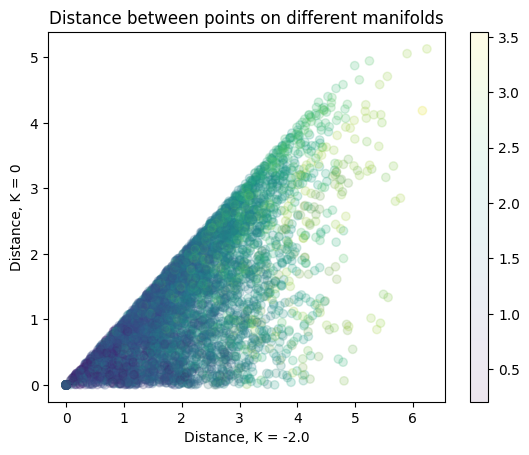

In [11]:
# Digression: is there a monotonic relationship between pairwise distances across curvatures?
# I guess there isn't

K1 = -2.0
K2 = -0

pm1 = ProductManifold(signature=[(K1, DIMENSION)])
pm2 = ProductManifold(signature=[(K2, DIMENSION)])

# Get a single sample
N = torch.distributions.MultivariateNormal(loc=torch.zeros(DIMENSION), covariance_matrix=torch.eye(DIMENSION))

# Get a single sample and raise to tangent plane (prepend with zero)
x = N.sample(sample_shape=(N_SAMPLES,))
x_tangent = torch.hstack([torch.zeros(N_SAMPLES, 1), x])

dists1 = pm1.pdist(pm1.expmap(x_tangent))
dists2 = pm2.pdist(pm2.expmap(x_tangent))

# Let's color by the max norm of the points in dists1
max_norms1 = pm1.dist(pm1.expmap(x_tangent), pm1.mu0)
max_norms2 = pm2.dist(pm2.expmap(x_tangent), pm2.mu0)
max_pairwise_norms = torch.max(max_norms1[:, None], max_norms2[None, :]).squeeze()

plt.scatter(
    dists1.detach().cpu().numpy().flatten(),
    dists2.detach().cpu().numpy().flatten(),
    alpha=0.1,
    c=max_pairwise_norms.detach().cpu().numpy(),
)
plt.xlabel(f"Distance, K = {K1}")
plt.ylabel(f"Distance, K = {K2}")
plt.colorbar()
plt.title("Distance between points on different manifolds")

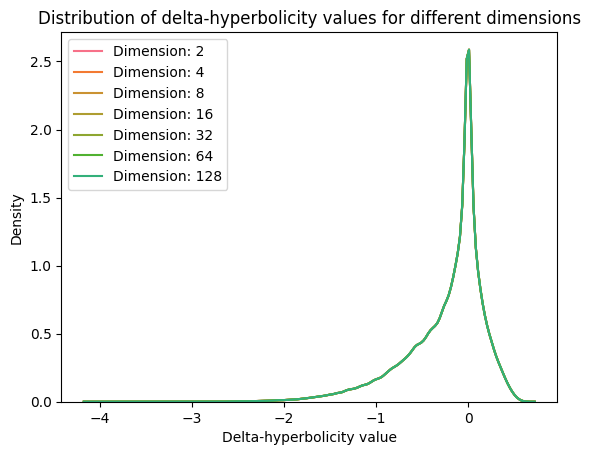

In [12]:
# Experiment 2: How does delta change with dimension?

# For this one, we can try to truncate a large sample

dims = [2, 4, 8, 16, 32, 64, 128]

N = torch.distributions.MultivariateNormal(loc=torch.zeros(max(dims)), covariance_matrix=torch.eye(max(dims)))

# Get a single sample
x = N.sample(sample_shape=(N_SAMPLES,))
x_tangent = torch.hstack([torch.zeros(N_SAMPLES, 1), x])

all_deltas = []
for dim in dims:
    pm_d = ProductManifold(signature=[(CURVATURE, dim)])

    # Get the distance
    dists = pm.pdist(pm.expmap(x_tangent[:, : dim + 1]))
    deltas = D_FUNC(dists)

    all_deltas.append(deltas)

# KDE plot
for i, deltas in enumerate(all_deltas):
    sns.kdeplot(deltas.detach().cpu().numpy().flatten(), label=f"Dimension: {dims[i]}", color=colors[i])
plt.xlabel("Delta-hyperbolicity value")
plt.ylabel("Density")
plt.title("Distribution of delta-hyperbolicity values for different dimensions")
plt.legend()
plt.show()

KeyboardInterrupt: 

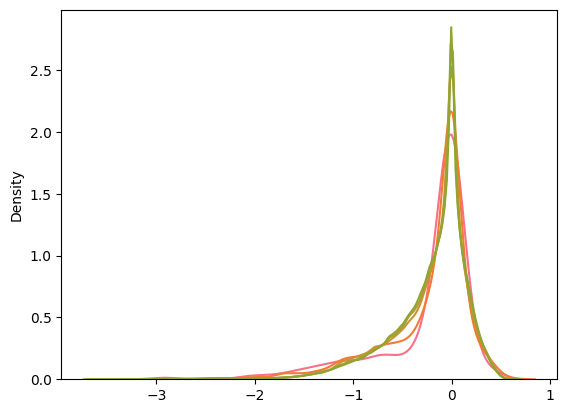

In [13]:
# Experiment 3: How does delta change with sample size?

sample_sizes = [10, 20, 50, 100, 200, 500, 1000]

N = torch.distributions.MultivariateNormal(loc=torch.zeros(max(dims)), covariance_matrix=torch.eye(max(dims)))

# Get a single sample
x = N.sample(sample_shape=(max(sample_sizes),))
x_tangent = torch.hstack([torch.zeros(max(sample_sizes), 1), x])

all_deltas = []
for sample_size in sample_sizes:
    pm_d = ProductManifold(signature=[(CURVATURE, DIMENSION)])

    # Get the distance
    dists = pm.pdist(pm.expmap(x_tangent[:sample_size]))
    deltas = D_FUNC(dists)

    all_deltas.append(deltas)

# KDE plot
for i, deltas in enumerate(all_deltas):
    sns.kdeplot(deltas.detach().cpu().numpy().flatten(), label=f"Sample size: {sample_sizes[i]}", color=colors[i])
plt.xlabel("Delta-hyperbolicity value")
plt.ylabel("Density")
plt.title("Distribution of delta-hyperbolicity values for different sample sizes")
plt.legend()
plt.show()

## Counter Examples

NameError: name 'delta_hyperbolicity' is not defined